# LICENSE PLATE DETECTION

### YOLO V3

In [4]:
!git clone https://github.com/roboflow-ai/keras-yolo3

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 169, done.
remote: Total 169 (delta 0), reused 0 (delta 0), pack-reused 169
Receiving objects: 100% (169/169), 172.74 KiB | 625.00 KiB/s, done.
Resolving deltas: 100% (80/80), done.


In [2]:
!curl -L "https://app.roboflow.com/ds/hTj8Pr7g7U?key=q9kdROYojM" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   897  100   897    0     0    269      0  0:00:03  0:00:03 --:--:--   269     0
100 2120k  100 2120k    0     0   515k      0  0:00:04  0:00:04 --:--:-- 23.5M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/2images1_png.rf.5de47b3b58bc776388f9547915f46edf.jpg  
 extracting: test/2images41_png.rf.2f711be90f9f9e796139a02cb45fe9ba.jpg  
 extracting: test/2images45_png.rf.cbcc994c49d1a2ca5e7bc52cb9b2a1a3.jpg  
 extracting: test/3images22_png.rf.b139cdb6065c658e0c7acc2124854383.jpg  
 extracting: test/3images34_png.rf.9a25c14870c5acae15ee0f159a9707b4.jpg  
 extracting: test/3images4_png.rf.a3d6d0b11320142ada8e8347c918dc30.jpg  
 extracting: test/6images3_png.rf.8b1268f1823ea224077f537939c2ccba.jpg  
 extracting: test/7images0_png.rf.fb9d6e1e739

In [5]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-01-18 12:01:19--  https://pjreddie.com/media/files/yolov3.weights
Translacja pjreddie.com (pjreddie.com)... 128.208.4.108
Łączenie się z pjreddie.com (pjreddie.com)|128.208.4.108|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 248007048 (237M) [application/octet-stream]
Zapis do: `yolov3.weights'

yolov3.weights      100%[===================>] 236,52M  17,0MB/s     w 15s     

2023-01-18 12:01:35 (15,4 MB/s) - zapisano `yolov3.weights' [248007048/248007048]



In [6]:
from keras.layers import ELU, PReLU, LeakyReLU

In [10]:
!python keras-yolo3/convert.py keras-yolo3/yolov3.cfg yolov3.weights model_data/yolo.h5

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

2023-01-18 12:03:25.001841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 12:03:25.002402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section convolutional_2
conv2d bn leaky (1, 1, 64, 32)
Parsing section convolutional_3
conv2d bn leaky (3, 3, 32, 64)
Parsing section shortcut_0
Parsing sectio

Total params: 62,001,757
Trainable params: 61,949,149
Non-trainable params: 52,608
__________________________________________________________________________________________________
None
Saved Keras model to model_data/yolo.h5
Read 62001757 of 62001757.0 from Darknet weights.


In [ ]:
"""
Self-contained Python script to train YOLOv3 on your own dataset
"""

import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data


def _main():
    annotation_path = './train/_annotations.txt'  # path to Roboflow data annotations
    log_dir = './logs/000/'                 # where we're storing our logs
    classes_path = './train/_classes.txt'         # path to Roboflow class names
    anchors_path = './model_data/yolo_anchors.txt'
    class_names = get_classes(classes_path)
    print("-------------------CLASS NAMES-------------------")
    print(class_names)
    print("-------------------CLASS NAMES-------------------")
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (256,256) # multiple of 32, hw      default = (416,416)

    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='./model_data/tiny_yolo_weights.h5')
    else:
        model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='./model_data/yolo.h5') # make sure you know what you freeze

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

    val_split = 0.2 # set the size of the validation set
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size = 16
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=500,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 16 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=50,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

    # Further training if needed.


def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='./model_data/yolo.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='./model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

if __name__ == '__main__':
    _main()

# Prepare image to ocr

In [4]:
import cv2 as cv
from matplotlib import pyplot as plt

In [218]:
def grayscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv.erode(image, kernel, iterations=1)
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    image = cv.medianBlur(image, 3)
    return (image)

def thin_font(image):
    import numpy as np
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv.erode(image, kernel, iterations=1)
    image = cv.bitwise_not(image)
    return (image)

def thick_font(image):
    import numpy as np
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv.dilate(image, kernel, iterations=1)
    image = cv.bitwise_not(image)
    return (image)

def remove_borders(image):
    contours, heiarchy = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

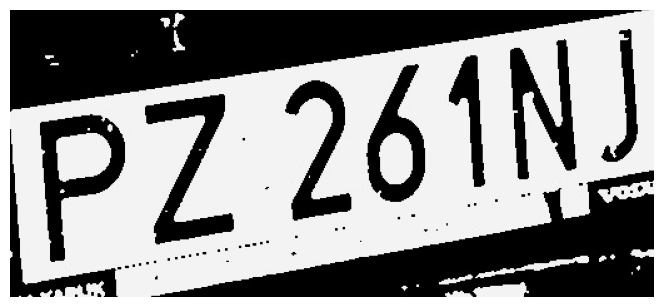

In [231]:
image_file = './img/img00.png'
img = cv.imread(image_file)
gray_image = grayscale(img)
thresh, im_bw = cv.threshold(gray_image, 100, 150, cv.THRESH_BINARY)
no_noise = noise_removal(im_bw)
# eroded_image = thin_font(no_noise)
# dilated_image = thick_font(eroded_image)
no_borders = remove_borders(no_noise)
cv.imwrite("temp/no_borders.jpg", no_borders)
display('temp/no_borders.jpg')

In [169]:
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

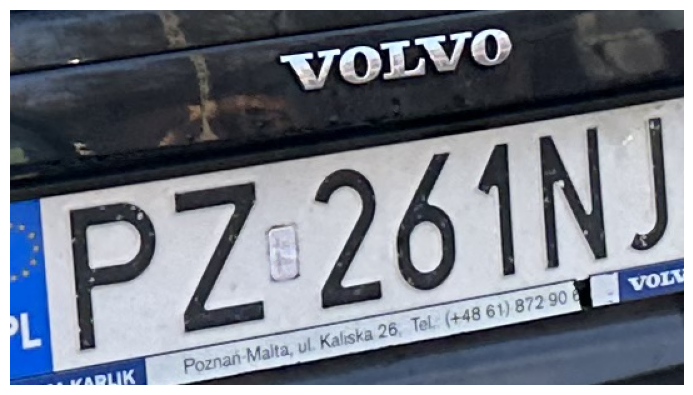

In [170]:
display(image_file)

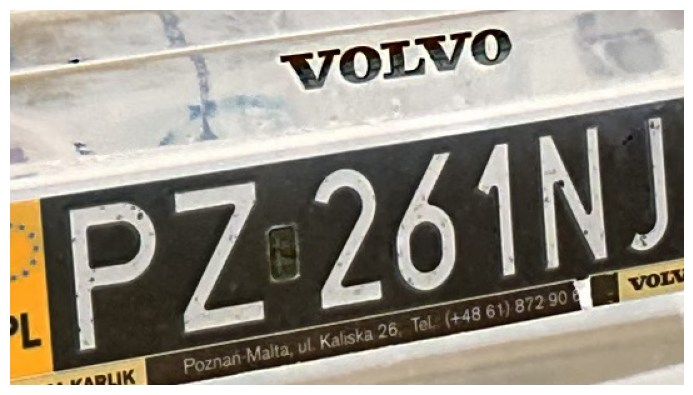

In [171]:
inverted_image = cv.bitwise_not(img)
cv.imwrite("temp/inverted.jpg", inverted_image)
display("temp/inverted.jpg")

In [172]:
def grayscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [203]:
gray_image = grayscale(img)
cv.imwrite("temp/gray.jpg", gray_image)

True

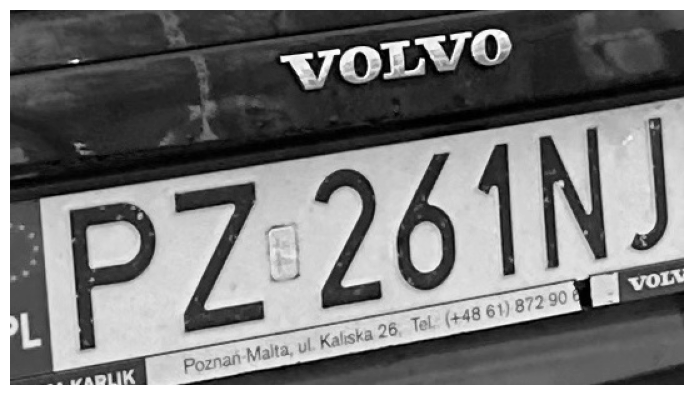

In [204]:
display("temp/gray.jpg")

In [254]:
thresh, im_bw = cv.threshold(gray_image, 170, 210, cv.THRESH_BINARY)
cv.imwrite("temp/bw_image.jpg", im_bw)

True

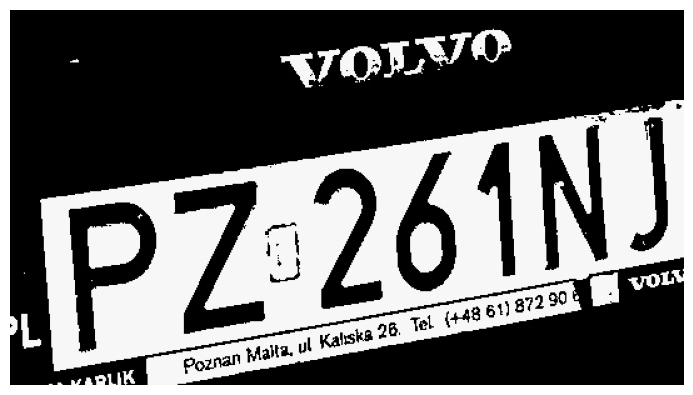

In [255]:
display("temp/bw_image.jpg")

In [207]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv.erode(image, kernel, iterations=1)
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    image = cv.medianBlur(image, 3)
    return (image)

In [208]:
no_noise = noise_removal(im_bw)
cv.imwrite("temp/no_noise.jpg", no_noise)

True

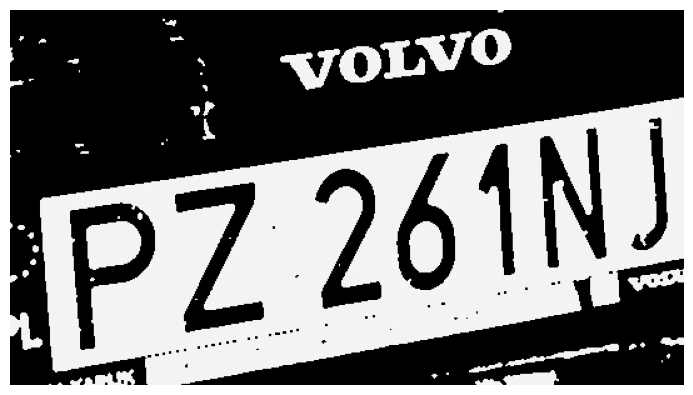

In [209]:
display("temp/no_noise.jpg")

In [210]:
def thin_font(image):
    import numpy as np
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv.erode(image, kernel, iterations=1)
    image = cv.bitwise_not(image)
    return (image)

In [211]:
eroded_image = thin_font(no_noise)
cv.imwrite("temp/eroded_image.jpg", eroded_image)

True

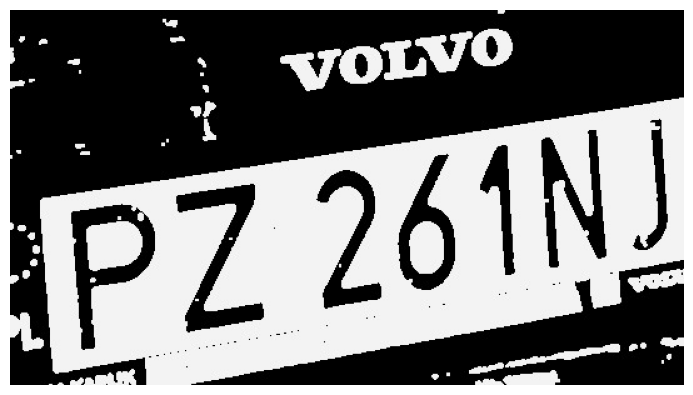

In [212]:
display("temp/eroded_image.jpg")

In [213]:
def thick_font(image):
    import numpy as np
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv.dilate(image, kernel, iterations=1)
    image = cv.bitwise_not(image)
    return (image)

In [214]:
dilated_image = thick_font(no_noise)
cv.imwrite("temp/dilated_image.jpg", dilated_image)

True

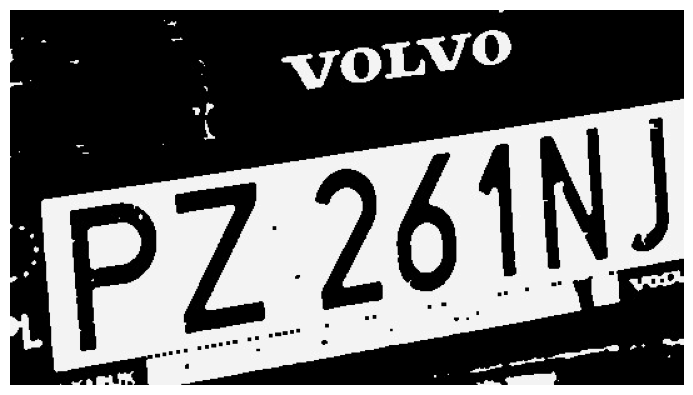

In [215]:
display("temp/dilated_image.jpg")

In [216]:
def remove_borders(image):
    contours, heiarchy = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

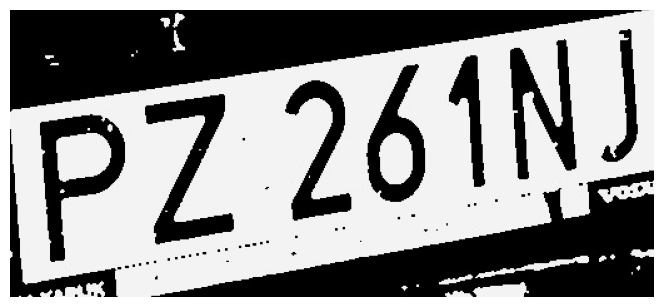

In [217]:
no_borders = remove_borders(no_noise)
cv.imwrite("temp/no_borders.jpg", no_borders)
display('temp/no_borders.jpg')